In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Amazonas - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_AM.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amazonas - Consumo de Cimento (t),Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,28.193,0.695898,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,11283.694800,0.745671,1.284537e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,31.226,0.696043,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,11377.134800,0.745986,1.291713e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,33.484,0.696187,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,11466.977022,0.746301,1.298888e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,31.596,0.696332,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,11551.599522,0.746616,1.306063e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,32.919,0.696476,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,11632.378833,0.746931,1.313239e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37456.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37394.661846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37304.892245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37191.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


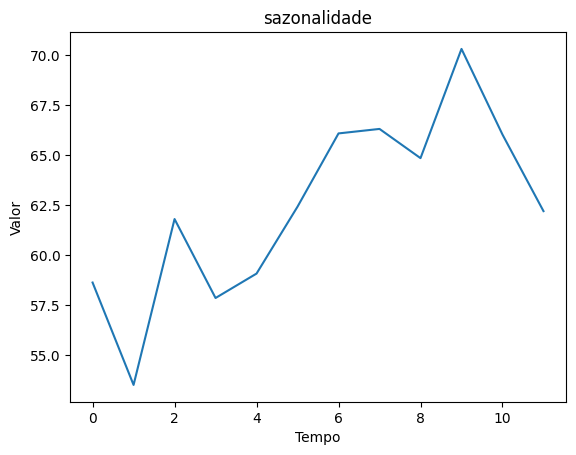

,sazonalidade
sazonalidade,
0,58.629342
1,53.507726
2,61.805183
3,57.855957
4,59.077386
5,62.424988
6,66.088767
7,66.313536
8,64.851720


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Amazonas - Consumo de Cimento (t)
0,2003-1,0.695898,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,11283.694800,0.745671,1.284537e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,58.629342,28.193
1,2003-2,0.696043,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,11377.134800,0.745986,1.291713e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,53.507726,31.226
2,2003-3,0.696187,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,11466.977022,0.746301,1.298888e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,61.805183,33.484
3,2003-4,0.696332,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,11551.599522,0.746616,1.306063e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,57.855957,31.596
4,2003-5,0.696476,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,11632.378833,0.746931,1.313239e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,59.077386,32.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37456.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.077386,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37394.661846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.424988,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37304.892245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.088767,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37191.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.313536,NaN


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      39.696
1      56.005
2      39.376
3      59.327
4      40.816
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Amazonas - Consumo de Cimento (t), Length: 249, dtype: float64

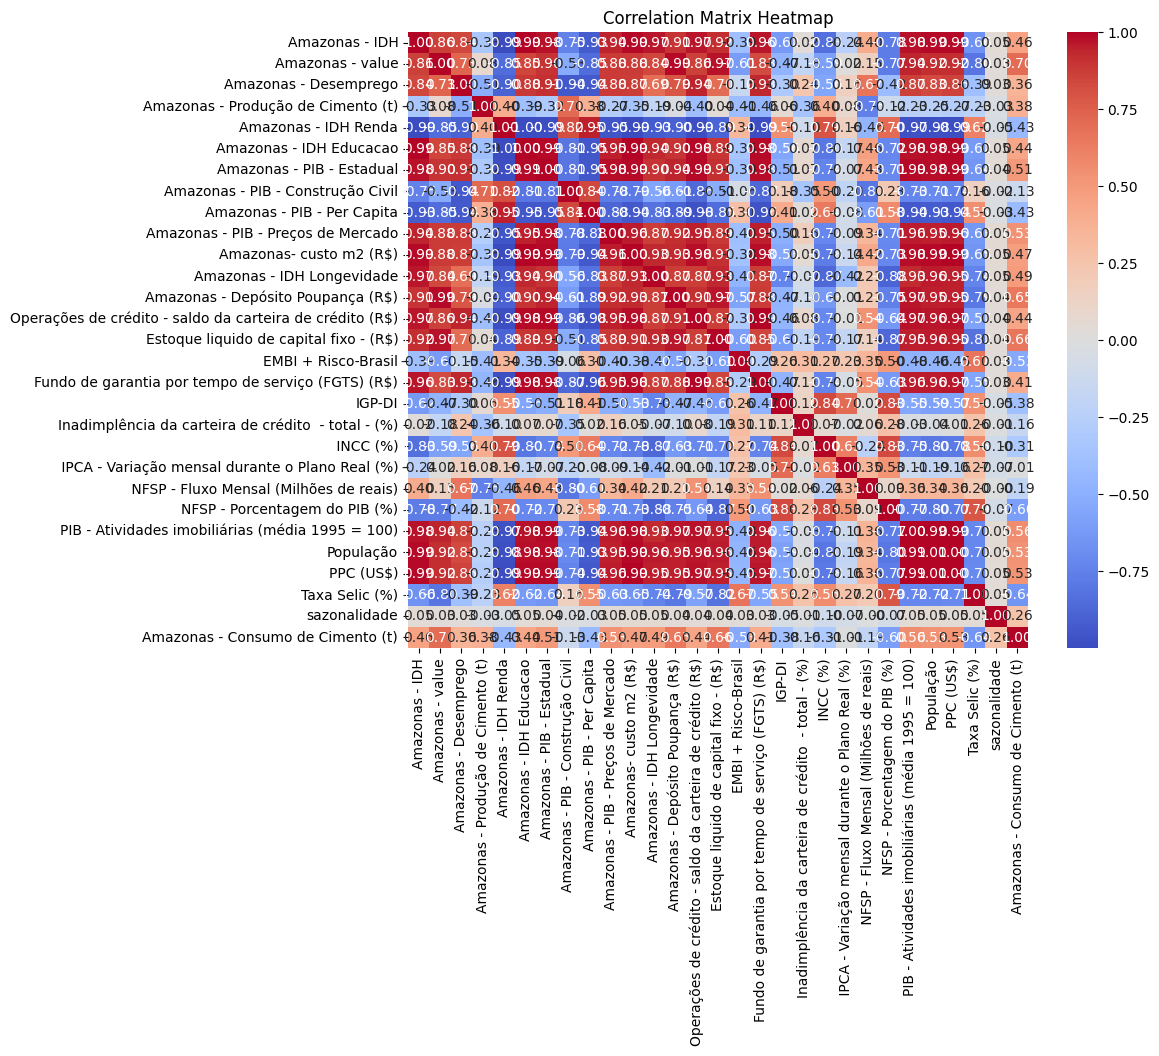

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Amazonas - IDH,2.912740e+09
1,Amazonas - value,9.009870e+04
2,Amazonas - Desemprego,5.757725e+04
3,Amazonas - Produção de Cimento (t),7.915881e+04
4,Amazonas - IDH Renda,3.051108e+08
5,Amazonas - IDH Educacao,1.319333e+09
6,Amazonas - PIB - Estadual,6.059038e+07
7,Amazonas - PIB - Construção Civil,7.365532e+06
8,Amazonas - PIB - Per Capita,7.401892e+08
9,Amazonas - PIB - Preços de Mercado,5.604639e+08


In [40]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 2


,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,4.318518e+07,11283.694800,0.745671,1.284537e+06,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,58.629342
1,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,4.320154e+07,11377.134800,0.745986,1.291713e+06,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,53.507726
2,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,4.321789e+07,11466.977022,0.746301,1.298888e+06,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,61.805183
3,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,4.323425e+07,11551.599522,0.746616,1.306063e+06,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,57.855957
4,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,4.325060e+07,11632.378833,0.746931,1.313239e+06,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,59.077386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.536520,12.728440,36.487161,0.658439,0.716459,5.583488e+07,2.437451e+06,4.428295e+07,24458.194818,0.768230,2.961434e+06,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,66.313536
176,0.538010,12.715207,35.825483,0.658471,0.716347,5.583822e+07,2.438197e+06,4.428794e+07,24555.001487,0.768110,2.972593e+06,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,64.851720
177,0.539679,12.701973,35.241638,0.658503,0.716235,5.584156e+07,2.438943e+06,4.429293e+07,24650.218275,0.767989,2.983752e+06,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,70.315601
178,0.540248,12.688740,34.630908,0.658535,0.716123,5.584490e+07,2.439689e+06,4.429792e+07,24743.544275,0.767868,2.994911e+06,3.083099e+06,7.776397e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,1.989930e+08,419.430070,1.004174,66.030763


In [41]:
input_data = data.iloc[:split_index + 1,1:]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.052061,0.572912,1.000000,0.000000,0.000000,0.613647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108706,0.015954,1.000000,0.790380,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.000000,0.807549,0.304715
1,0.050819,0.580847,0.994755,0.005888,0.006890,0.624331,0.014632,0.006893,0.012908,0.003507,0.000207,0.011007,0.058377,0.005176,0.936603,0.788742,0.968765,0.909144,0.544990,0.965719,0.001689,0.008302,0.003703,0.687691,0.000000
2,0.049577,0.579830,0.989509,0.011777,0.013780,0.635015,0.029264,0.013521,0.025815,0.007014,0.000221,0.022015,0.100305,0.001016,0.906543,0.788333,0.948151,0.853620,0.532585,0.927412,0.003378,0.016605,0.007525,1.000000,0.493665
3,0.048335,0.583658,0.984264,0.017665,0.020670,0.645699,0.043896,0.019764,0.038723,0.010520,0.000380,0.033022,0.211591,0.000000,0.858675,0.787696,0.928398,0.828878,0.504220,0.885588,0.005067,0.024907,0.011436,0.616940,0.258702
4,0.047093,0.590201,0.979019,0.023553,0.027560,0.656383,0.058528,0.025723,0.051630,0.014027,0.000881,0.044030,0.358835,0.002380,0.824839,0.784532,0.970256,0.796137,0.515509,0.838034,0.007149,0.033209,0.015243,0.788236,0.331372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.890502,0.085035,0.006141,0.986684,0.998392,0.036603,0.982145,0.971902,0.924652,0.819552,0.953376,0.889786,0.201733,0.900757,0.168620,0.816187,0.020697,0.038179,0.496222,0.033352,0.973515,0.986456,0.986889,0.043126,0.761893
176,0.887794,0.063261,0.007019,0.984781,0.998794,0.041832,0.986609,0.979044,0.919707,0.825006,0.953950,0.885419,0.191748,0.884182,0.176428,0.769775,0.019895,0.016717,0.473326,0.034217,0.980116,0.989842,0.990433,0.169097,0.674921
177,0.885086,0.044048,0.007896,0.982879,0.999196,0.047061,0.991073,0.986068,0.914762,0.830460,0.956916,0.881053,0.184535,0.927328,0.174368,0.685140,0.020180,0.004270,0.425824,0.035996,0.986717,0.993228,0.993830,0.265091,1.000000
178,0.882379,0.023951,0.008773,0.980976,0.999598,0.052290,0.995536,0.992953,0.909817,0.835913,0.958509,0.876686,0.179849,0.981078,0.197726,0.619023,0.007298,0.000000,0.448015,0.039184,0.993358,0.996614,0.997134,0.355727,0.745070


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.052061,0.572912,1.000000,0.000000,0.000000,0.613647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108706,0.015954,1.000000,0.790380,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.000000,0.807549,0.304715
1,0.050819,0.580847,0.994755,0.005888,0.006890,0.624331,0.014632,0.006893,0.012908,0.003507,0.000207,0.011007,0.058377,0.005176,0.936603,0.788742,0.968765,0.909144,0.544990,0.965719,0.001689,0.008302,0.003703,0.687691,0.000000
2,0.049577,0.579830,0.989509,0.011777,0.013780,0.635015,0.029264,0.013521,0.025815,0.007014,0.000221,0.022015,0.100305,0.001016,0.906543,0.788333,0.948151,0.853620,0.532585,0.927412,0.003378,0.016605,0.007525,1.000000,0.493665
3,0.048335,0.583658,0.984264,0.017665,0.020670,0.645699,0.043896,0.019764,0.038723,0.010520,0.000380,0.033022,0.211591,0.000000,0.858675,0.787696,0.928398,0.828878,0.504220,0.885588,0.005067,0.024907,0.011436,0.616940,0.258702
4,0.047093,0.590201,0.979019,0.023553,0.027560,0.656383,0.058528,0.025723,0.051630,0.014027,0.000881,0.044030,0.358835,0.002380,0.824839,0.784532,0.970256,0.796137,0.515509,0.838034,0.007149,0.033209,0.015243,0.788236,0.331372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.947183,0.297725,0.014102,0.992768,0.985965,0.013001,0.920653,0.898303,0.976239,0.738052,0.973534,0.937006,0.423280,0.849212,0.061396,0.803166,0.094130,0.144755,0.772284,0.015040,0.918734,0.945698,0.938086,0.461869,0.761893
164,0.939638,0.282077,0.011282,0.994214,0.987888,0.010401,0.926702,0.904316,0.972845,0.746717,0.971665,0.933675,0.387661,0.842872,0.095565,0.850835,0.087555,0.133956,0.741958,0.016631,0.921412,0.949109,0.942492,0.424663,0.674921
165,0.932093,0.265736,0.008461,0.995661,0.989810,0.007801,0.932751,0.910559,0.969451,0.755381,0.970441,0.930344,0.351781,0.895026,0.096417,0.875483,0.083404,0.141095,0.686725,0.018850,0.924089,0.952520,0.946808,0.397941,1.000000
166,0.924547,0.251823,0.005641,0.997107,0.991732,0.005201,0.938801,0.917032,0.966056,0.764046,0.968444,0.927013,0.319424,0.964451,0.052056,0.869042,0.075773,0.102393,0.792808,0.020846,0.926628,0.955931,0.951146,0.462657,0.745070


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      39.696
1      56.005
2      39.376
3      59.327
4      40.816
        ...  
163    23.387
164    38.399
165    39.652
166    40.204
167    21.625
Name: Amazonas - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 25)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
132,0.866311,0.675686,0.259839,0.750654,0.882319,0.282125,0.843727,0.730227,0.716896,1.000000,0.824957,1.000000,0.116855,0.767559,0.297841,0.063050,0.368307,0.710818,0.600233,0.076793,0.912582,0.834889,0.820470,0.230530,0.304715
133,0.875334,0.663234,0.256916,0.754858,0.886388,0.267239,0.842696,0.736881,0.714096,0.986254,0.832587,0.999030,0.128078,0.728075,0.310249,0.064498,0.356043,0.737933,0.683286,0.080065,0.914530,0.838610,0.823328,0.254634,0.000000
134,0.884357,0.652014,0.253992,0.759063,0.890458,0.252353,0.841665,0.743289,0.711295,0.972508,0.840712,0.998060,0.131464,0.716376,0.298259,0.087497,0.365871,0.731922,0.691333,0.083086,0.916477,0.842332,0.826215,0.336791,0.493665
135,0.893379,0.640731,0.251069,0.763268,0.894528,0.237467,0.840634,0.749566,0.708495,0.958762,0.849002,0.997090,0.133803,0.712712,0.264133,0.096187,0.374560,0.722500,0.683763,0.085709,0.918425,0.846053,0.829052,0.183003,0.258702
136,0.902402,0.629422,0.248145,0.767473,0.898597,0.222582,0.839602,0.755479,0.705695,0.945016,0.856512,0.996121,0.134128,0.716291,0.283400,0.110126,0.347016,0.735417,0.750790,0.089485,0.919796,0.849774,0.831800,0.160974,0.331372
137,0.911425,0.617770,0.245221,0.771677,0.902667,0.207696,0.838571,0.761413,0.702894,0.931270,0.863910,0.995151,0.136063,0.719365,0.345980,0.110851,0.340984,0.736663,0.748426,0.091963,0.921167,0.853496,0.834534,0.205407,0.530541
138,0.920448,0.606170,0.242298,0.775882,0.906736,0.192810,0.837540,0.767508,0.700094,0.917524,0.872003,0.994181,0.140590,0.727261,0.355524,0.115684,0.333970,0.750484,0.765274,0.093682,0.922539,0.857217,0.836982,0.250543,0.748521
139,0.929471,0.594420,0.239374,0.780087,0.910806,0.177924,0.836509,0.773561,0.697294,0.903778,0.881396,0.993211,0.145335,0.733285,0.388252,0.116796,0.316991,0.781650,0.799973,0.094876,0.922662,0.860938,0.839358,0.302580,0.761893
140,0.938494,0.582750,0.236450,0.784292,0.914876,0.163038,0.835478,0.778748,0.694493,0.890032,0.891920,0.992241,0.149790,0.736810,0.392252,0.093280,0.324046,0.780630,0.803815,0.095765,0.922785,0.864660,0.841836,0.229929,0.674921
141,0.947516,0.571085,0.233527,0.788497,0.918945,0.148152,0.834447,0.784007,0.691693,0.876287,0.904492,0.991271,0.156217,0.787147,0.401389,0.054593,0.324890,0.771685,0.692895,0.095412,0.922908,0.868381,0.844376,0.334488,1.000000


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 25)

In [48]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [49]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.2,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [50]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [51]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[718770737, 2068189162, 3719448664, 3319388317, 3317771272, 752689725, 2439290672, 3600160659, 1767687833, 2732983762]


Step: 0 ___________________________________________
val_loss: 319.5587158203125
winner_seed: 718770737


Step: 1 ___________________________________________
val_loss: 276.3520202636719
winner_seed: 2068189162


Step: 2 ___________________________________________
val_loss: 316.189697265625


Step: 3 ___________________________________________
val_loss: 332.03216552734375


Step: 4 ___________________________________________
val_loss: 282.8062438964844


Step: 5 ___________________________________________
val_loss: 315.9031677246094


Step: 6 ___________________________________________
val_loss: 313.8656005859375


Step: 7 ___________________________________________
val_loss: 311.1192626953125


Step: 8 ___________________________________________
val_loss: 293.2550048828125


Step: 9 ___________________________________________
val_loss: 309.8739013671875


final_seed: 

In [52]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2068189162

Epoch 1/10000
4/4 [==============================] - 2s 119ms/step - loss: 4237.9399 - val_loss: 445.7437
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 310.8627 - val_loss: 991.3460
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 210.1067 - val_loss: 859.2327
Epoch 4/10000
4/4 [==============================] - 0s 8ms/step - loss: 211.7257 - val_loss: 983.9240
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 209.1515 - val_loss: 1290.0265
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 221.5345 - val_loss: 1030.0740
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 214.0206 - val_loss: 945.0215
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 208.9818 - val_loss: 879.3961
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 212.8999 - val_loss: 1022.1136
Epoch 10/10000
4/4 [==============================] - 0s 9ms/step 

4/4 [==============================] - 0s 11ms/step - loss: 140.1807 - val_loss: 633.5800
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 143.2052 - val_loss: 581.3262
Epoch 159/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.6812 - val_loss: 365.7999
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.5596 - val_loss: 357.9409
Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.6556 - val_loss: 578.1599
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 126.8405 - val_loss: 395.2358
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 136.0871 - val_loss: 422.9129
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 120.8850 - val_loss: 403.0202
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step - loss: 108.6217 - val_loss: 384.1859
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - l

4/4 [==============================] - 0s 9ms/step - loss: 95.1227 - val_loss: 373.0671
Epoch 236/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.8518 - val_loss: 524.9731
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 98.3561 - val_loss: 386.0564
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.9335 - val_loss: 352.8941
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.3180 - val_loss: 363.9304
Epoch 240/10000
4/4 [==============================] - 0s 8ms/step - loss: 90.9514 - val_loss: 427.7112
Epoch 241/10000
4/4 [==============================] - 0s 8ms/step - loss: 92.0382 - val_loss: 468.2578
Epoch 242/10000
4/4 [==============================] - 0s 8ms/step - loss: 123.1280 - val_loss: 339.7576
Epoch 243/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.9551 - val_loss: 389.2232
Epoch 244/10000
4/4 [==============================] - 0s 9ms/step - loss: 99

4/4 [==============================] - 0s 10ms/step - loss: 83.0182 - val_loss: 421.8461
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 84.4967 - val_loss: 416.1699
Epoch 393/10000
4/4 [==============================] - 0s 9ms/step - loss: 80.2626 - val_loss: 375.1758
Epoch 394/10000
4/4 [==============================] - 0s 9ms/step - loss: 83.4901 - val_loss: 486.9168
Epoch 395/10000
4/4 [==============================] - 0s 8ms/step - loss: 79.0825 - val_loss: 354.4075
Epoch 396/10000
4/4 [==============================] - 0s 8ms/step - loss: 83.9440 - val_loss: 434.8144
Epoch 397/10000
4/4 [==============================] - 0s 8ms/step - loss: 81.6803 - val_loss: 428.8966
Epoch 398/10000
4/4 [==============================] - 0s 8ms/step - loss: 80.0363 - val_loss: 491.6693
Epoch 399/10000
4/4 [==============================] - 0s 8ms/step - loss: 82.9922 - val_loss: 381.1652
Epoch 400/10000
4/4 [==============================] - 0s 9ms/step - loss: 85.4

Epoch 470/10000
4/4 [==============================] - 0s 8ms/step - loss: 79.2369 - val_loss: 380.2737
Epoch 471/10000
4/4 [==============================] - 0s 8ms/step - loss: 83.7872 - val_loss: 376.5430
Epoch 472/10000
4/4 [==============================] - 0s 8ms/step - loss: 76.5831 - val_loss: 379.4875
Epoch 473/10000
4/4 [==============================] - 0s 8ms/step - loss: 80.9850 - val_loss: 383.4738
Epoch 474/10000
4/4 [==============================] - 0s 9ms/step - loss: 82.3546 - val_loss: 374.7012
Epoch 475/10000
4/4 [==============================] - 0s 10ms/step - loss: 83.0015 - val_loss: 404.0803
Epoch 476/10000
4/4 [==============================] - 0s 11ms/step - loss: 78.2087 - val_loss: 369.4285
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 81.3403 - val_loss: 359.0710
Epoch 478/10000
4/4 [==============================] - 0s 9ms/step - loss: 78.0451 - val_loss: 449.1680
Epoch 479/10000
4/4 [==============================] - 0s 9ms

Epoch 627/10000
4/4 [==============================] - 0s 8ms/step - loss: 73.3862 - val_loss: 360.7738
Epoch 628/10000
4/4 [==============================] - 0s 8ms/step - loss: 73.6865 - val_loss: 388.2749
Epoch 629/10000
4/4 [==============================] - 0s 9ms/step - loss: 74.9561 - val_loss: 384.5886
Epoch 630/10000
4/4 [==============================] - 0s 9ms/step - loss: 73.1990 - val_loss: 361.2797
Epoch 631/10000
4/4 [==============================] - 0s 10ms/step - loss: 74.5348 - val_loss: 423.1598
Epoch 632/10000
4/4 [==============================] - 0s 9ms/step - loss: 75.6768 - val_loss: 368.8573
Epoch 633/10000
4/4 [==============================] - 0s 9ms/step - loss: 70.3612 - val_loss: 352.9659
Epoch 634/10000
4/4 [==============================] - 0s 10ms/step - loss: 71.7710 - val_loss: 357.8579
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 73.8461 - val_loss: 356.1265
Epoch 636/10000
4/4 [==============================] - 0s 10ms

Epoch 784/10000
4/4 [==============================] - 0s 8ms/step - loss: 121.4645 - val_loss: 429.0986
Epoch 785/10000
4/4 [==============================] - 0s 8ms/step - loss: 123.6438 - val_loss: 367.5923
Epoch 786/10000
4/4 [==============================] - 0s 8ms/step - loss: 141.6631 - val_loss: 367.3201
Epoch 787/10000
4/4 [==============================] - 0s 9ms/step - loss: 127.6620 - val_loss: 520.5417
Epoch 788/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.8953 - val_loss: 469.0486
Epoch 789/10000
4/4 [==============================] - 0s 9ms/step - loss: 121.0361 - val_loss: 423.4450
Epoch 790/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.8236 - val_loss: 434.5647
Epoch 791/10000
4/4 [==============================] - 0s 9ms/step - loss: 105.2687 - val_loss: 467.1215
Epoch 792/10000
4/4 [==============================] - 0s 9ms/step - loss: 101.2506 - val_loss: 464.9271
Epoch 793/10000
4/4 [==============================] - 

Epoch 941/10000
4/4 [==============================] - 0s 9ms/step - loss: 99.7866 - val_loss: 325.8156
Epoch 942/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.8142 - val_loss: 363.6243
Epoch 943/10000
4/4 [==============================] - 0s 9ms/step - loss: 88.0119 - val_loss: 428.6268
Epoch 944/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.5316 - val_loss: 366.2195
Epoch 945/10000
4/4 [==============================] - 0s 8ms/step - loss: 81.1442 - val_loss: 417.4125
Epoch 946/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.4809 - val_loss: 464.1429
Epoch 947/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.8198 - val_loss: 954.4362
Epoch 948/10000
4/4 [==============================] - 0s 9ms/step - loss: 258.3929 - val_loss: 676.4311
Epoch 949/10000
4/4 [==============================] - 0s 9ms/step - loss: 209.2825 - val_loss: 657.6659
Epoch 950/10000
4/4 [==============================] - 0s 9m

Epoch 1019/10000
4/4 [==============================] - 0s 8ms/step - loss: 137.3871 - val_loss: 673.2818
Epoch 1020/10000
4/4 [==============================] - 0s 8ms/step - loss: 151.2306 - val_loss: 451.9657
Epoch 1021/10000
4/4 [==============================] - 0s 9ms/step - loss: 138.1182 - val_loss: 516.2217
Epoch 1022/10000
4/4 [==============================] - 0s 9ms/step - loss: 130.7382 - val_loss: 584.9724
Epoch 1023/10000
4/4 [==============================] - 0s 9ms/step - loss: 122.5711 - val_loss: 524.2054
Epoch 1024/10000
4/4 [==============================] - 0s 9ms/step - loss: 141.4380 - val_loss: 399.4742
Epoch 1025/10000
4/4 [==============================] - 0s 9ms/step - loss: 145.4353 - val_loss: 472.9290
Epoch 1026/10000
4/4 [==============================] - 0s 9ms/step - loss: 147.0681 - val_loss: 445.0405
Epoch 1027/10000
4/4 [==============================] - 0s 11ms/step - loss: 149.6091 - val_loss: 737.8487
Epoch 1028/10000
4/4 [=======================

4/4 [==============================] - 0s 9ms/step - loss: 109.5035 - val_loss: 380.2195
Epoch 1174/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.0681 - val_loss: 426.9012
Epoch 1175/10000
4/4 [==============================] - 0s 10ms/step - loss: 111.1026 - val_loss: 349.9073
Epoch 1176/10000
4/4 [==============================] - 0s 9ms/step - loss: 132.6605 - val_loss: 365.3146
Epoch 1177/10000
4/4 [==============================] - 0s 9ms/step - loss: 117.0090 - val_loss: 395.5968
Epoch 1178/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.4803 - val_loss: 386.1342
Epoch 1179/10000
4/4 [==============================] - 0s 9ms/step - loss: 113.6129 - val_loss: 383.6786
Epoch 1180/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.3556 - val_loss: 408.0271
Epoch 1181/10000
4/4 [==============================] - 0s 8ms/step - loss: 107.9614 - val_loss: 417.2355
Epoch 1182/10000
4/4 [==============================] - 0s 9ms

4/4 [==============================] - 0s 9ms/step - loss: 118.9504 - val_loss: 326.6711
Epoch 1328/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.8087 - val_loss: 303.5273
Epoch 1329/10000
4/4 [==============================] - 0s 8ms/step - loss: 119.8750 - val_loss: 329.9378
Epoch 1330/10000
4/4 [==============================] - 0s 8ms/step - loss: 114.1325 - val_loss: 315.6642
Epoch 1331/10000
4/4 [==============================] - 0s 8ms/step - loss: 116.8558 - val_loss: 303.1343
Epoch 1332/10000
4/4 [==============================] - 0s 8ms/step - loss: 113.8141 - val_loss: 307.2878
Epoch 1333/10000
4/4 [==============================] - 0s 9ms/step - loss: 112.4796 - val_loss: 353.3465
Epoch 1334/10000
4/4 [==============================] - 0s 8ms/step - loss: 114.4464 - val_loss: 310.2803
Epoch 1335/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.6812 - val_loss: 321.7393
Epoch 1336/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 10ms/step - loss: 99.4810 - val_loss: 347.9362
Epoch 1482/10000
4/4 [==============================] - 0s 10ms/step - loss: 111.6673 - val_loss: 364.3704
Epoch 1483/10000
4/4 [==============================] - 0s 10ms/step - loss: 97.4682 - val_loss: 352.8632
Epoch 1484/10000
4/4 [==============================] - 0s 9ms/step - loss: 100.8079 - val_loss: 380.6292
Epoch 1485/10000
4/4 [==============================] - 0s 10ms/step - loss: 114.5615 - val_loss: 357.3636
Epoch 1486/10000
4/4 [==============================] - 0s 8ms/step - loss: 99.4398 - val_loss: 356.8242
Epoch 1487/10000
4/4 [==============================] - 0s 8ms/step - loss: 102.6763 - val_loss: 350.1004
Epoch 1488/10000
4/4 [==============================] - 0s 8ms/step - loss: 112.2270 - val_loss: 347.2130
Epoch 1489/10000
4/4 [==============================] - 0s 8ms/step - loss: 102.3916 - val_loss: 353.9251
Epoch 1490/10000
4/4 [==============================] - 0s 8ms

Epoch 1636/10000
4/4 [==============================] - 0s 8ms/step - loss: 103.5727 - val_loss: 384.4540
Epoch 1637/10000
4/4 [==============================] - 0s 8ms/step - loss: 103.8565 - val_loss: 404.9956
Epoch 1638/10000
4/4 [==============================] - 0s 9ms/step - loss: 102.7381 - val_loss: 515.8792
Epoch 1639/10000
4/4 [==============================] - 0s 8ms/step - loss: 125.1122 - val_loss: 470.7540
Epoch 1640/10000
4/4 [==============================] - 0s 8ms/step - loss: 106.2323 - val_loss: 419.7919
Epoch 1641/10000
4/4 [==============================] - 0s 8ms/step - loss: 94.4512 - val_loss: 392.5590
Epoch 1642/10000
4/4 [==============================] - 0s 8ms/step - loss: 104.4479 - val_loss: 416.2094
Epoch 1643/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.9940 - val_loss: 389.7483
Epoch 1644/10000
4/4 [==============================] - 0s 9ms/step - loss: 110.3456 - val_loss: 400.5408
Epoch 1645/10000
4/4 [=========================

In [53]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [54]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,44.714355,44.395462,44.196819,44.468895,44.337666,44.358437,44.672607,45.221489,45.461952,45.428062,46.385059,45.723003
Target,42.731,36.026,34.609,40.787,39.823,39.957,52.048,53.567,46.239,51.066,51.684,44.907
Error,1.983356,8.369461,9.587818,3.681896,4.514664,4.401436,7.375393,8.345512,0.777046,5.637939,5.298939,0.816002


In [55]:
display(mae)
display(mape)

5.0657887

0.11791372

In [56]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [57]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[539.36383]] - Target[533.444]| =  Error: [[5.919861]]; MAPE:[[0.01109744]]


[array([[5.919861]], dtype=float32)]

5.919861

0.011097437